# Genetic Algorithm and Particle Swarm Optimization

## Importing Libraries

In [12]:
# uncomment the next line when running the file for the first time
# pip install optproblems

  Created wheel for optproblems: filename=optproblems-1.3-py3-none-any.whl size=2040690 sha256=3f1851c9afb171d2a1343cd51d8385fda0fa4f02cfe52de44b3dc27639f0e2bd
  Stored in directory: c:\users\geeta\appdata\local\pip\cache\wheels\52\6d\85\cae29bdf0723616b70cb1161ddeaa599b3f18297ff70ccf411
Successfully built optproblems



In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
# import optproblems
from optproblems import cec2005
from optproblems import Individual
# import BoundConstraintsRepair to repair variables that go out of bounds
from optproblems import BoundConstraintsRepair
import math
random.seed(40)
np.random.seed(40)

## Genetic Algortihm

## Particle Swarm Optimization

In [11]:
# # confirm fitness and error
# # informant, loop libraries to use
# class Particle:
#     """
#     Class that represents a candidate solution or a particle in the population of solutions/swarm
    
#     Attributes:
#         pos - position of the particle
#         vel - velocities of the particle along each dimension
#         output - the output of the function run on the particle
#         best_pos -  best position of the particle
#         best_output - best function output of the particle
#     """
#     def __init__(self, n_dim, bounds): 
        
#         self.n_dim = n_dim
#         self.pos = []  # particle position 
#         self.vel = []           # particle velocity
#         self.output = 0                # error individual
#         self.best_pos = []          # best position individual
#         self.bounds = bounds
        
#         for i in range(self.n_dim):
#             self.pos.append(np.random.random()) # start[i]?, check bounds?, bound?
#             self.vel.append(0) # np.random.random()
            
#     def get_func(funcname):
#         #number of dimensions. 
#         # Note that for many functions the number of variables is limited to 2, 10, 30, 50
#         if funcname == "f12":
#             f12 = cec2005.F12(self.n_dim)
#             func1 = f12
#             sol = Individual(phenome=self.pos)
#             func1.evaluate(sol)
#             val = sol.objective_values
#             err = 1-val
#             print(val)
#         return val, err
# #         min_bound = -math.pi
# #         max_bound = math.pi 
#         # create  bounds
# #         bounds = ([min_bound] * dims, [max_bound] * dims)
# #         repair = BoundConstraintsRepair(bounds, ["reflect"] * dims)
# #         rand_solution = Individual(phenome=self.pos)
# #         rand_solution.phenome = repair(rand_solution.phenome)
# #         func.evaluate(rand_solution)
# #         print("Random candidate solution and objective values:")  
# #         print(rand_solution.phenome, rand_solution.objective_values)  #print the radom candidate solution and the associated objective values
                
#     # evaluate current fitness
# #     def calculate_fitness(self, funcname): # self, cost func
# #         fitness, err = func(funcname)
# #         # check to see if the current position is an individual best
# #         if self.fitness < fitness:
# #             self.fitness = fitness
# #             self.best_pos = self.pos   

#     # update new particle velocity
#     def update_velocity(self, info_best_pos, swarm_best_pos):
#         alpha = 0.5 # inertia weight to decide the weight to give to the previous velocity value- between 0,1
#         beta = 1.25 # cognative weight
#         gamma =  1.30 # social weight
#         delta = 1.45 # global weight

#         for i in range(self.n_dim):
#             r1 = random.uniform(0,1)
#             r2 = random.uniform(0,1)
#             r3 = random.uniform(0,1)  # randint(), random.uniform is changed to range

#             personal_update = alpha * self.velocity_i[i]
#             own_best = beta * r1 * (self.best_pos[i]-self.pos[i])
#             informant_best = gamma * r2 * (info_best_pos[i]-self.pos[i])
#             global_best = delta * r3 * (swarm_best_pos[i]-self.pos[i])

#             self.vel[i]= personal_update + own_best + informant_best + global_best


#     # update the particle position based off new velocity updates
#     def update_position(self, eps):
#         for i in range(self.n_dim):
#             self.pos[i]+= eps * self.vel[i]
#              # adjust minimum position if neseccary
#             if self.pos[i] < self.bounds[0]:
#                 self.pos[i] = self.bounds[0]

#             # adjust maximum position if necessary
#             if self.pos[i] > self.bounds[1]:
#                 self.pos[i] = self.bounds[1]

                
# def get_informants(particles, num_informants):
#     ints = np.random.randint(0,len(particles),num_informants)
#     informants = []
#     info_best_pos = []
#     info_best_output = informants[0].best_pos
    
#     for i in range(len(particles)):
#         if i in ints:
#             informants.append(particles[i])
            
#     for p in particles:
#         if p.output < info_best_output:
#             info_best_fitness = p.fitness
#             info_best_pos = p.pos
            
#     return informants, info_best_pos

# def get_bounds(funcname):
#     min_bound = 0
#     max_bound = 0
#     if funcname == "f12":
#         min_bound = -math.pi
#         max_bound = math.pi 
        
#     return (min_bound, max_bound)
        
    
# def PSO (funcname,n_dim,num_particles,num_informants,iterations):
    
#     bounds = get_bounds(funcname)
#     particles = []
#     for i in range(num_particles): 
#         particles.append(Particle(n_dim, bounds))
    
#     err_crit = 0.00001
#     err = 999999999
#     informants = []
#     info_best_pos = []
#     swarm_best = particles[0]
    
#     eps = 0.9 # epsilon
#     informants, info_best_pos = get_informants(particles, num_informants)
# #     i = 0
# #     while i < iterations :
#     for i in range(iterations):
#         for particle in particles:
# #             particle.calculate_fitness(func_name)
#             output, err = particle.get_func(funcname)
#             # check to see if the current position is an individual best
#             if particle.output > output:
#                 particle.output = output
#                 particle.best_pos = particle.pos
                
#             if particle.output < swarm_best.output:
#                 swarm_best = particle

#         for particle in particles:
#             particle.update_velocity(info_best_pos, swarm_best.pos)
#             particle.update_position(eps)
            
# #         if err < err_crit:
# #             break
# #         i+=1
#         eps -= 0.0005
#     return swarm_best

In [97]:
class Particle:
    """
    Class that represents a candidate solution or a particle in the population of solutions/swarm.
    
    Attributes:
        n_dim - number of dimensions
        bounds - the maximum and minimum values for the positions and velocities and the initial range for the position
        pos - position of the particle
        vel - velocities of the particle along each dimension
        output - the output of the function run on the particle
        best_pos -  best position of the particle
        best_output - best function output of the particle
    """
    def __init__(self, n_dim, bounds): 
        
        self.n_dim = n_dim # represents number of dimensions
        self.bounds = bounds # represents bounds asscociated with the acceptable values 
        self.pos = np.random.uniform(self.bounds[2], self.bounds[3], self.n_dim)  # represents the particle's position 
        self.vel = np.random.uniform(self.bounds[4], self.bounds[5], self.n_dim) # represents particle's velocity
        self.output = 999999999 # represents the output of the objective function when run, for assessing the fitness of the solution
        self.best_pos = np.copy(self.pos) # represents the best solution/position of this particle
        self.best_output = self.output # represents the best (least) output value computed

        
    def update_velocity(self, info_best_pos, swarm_best_pos):
        """
        Method to update the velocity of the particle.
        
        Attributes:
            info_best_pos - best position found by one of the informants
            swarm_best_pos - best position found by a particle in the swarm
        """
        alpha = 0.7 # inertia weight to decide the weight to give to the previous velocity value- between 0,1
        beta = 2 # cognative weight
        gamma =  0.001 # social weight
        delta = 1.999 # global weight

        for i in range(self.n_dim):
            # to get 3 uniformly distributed random numbers between 0 and 1 (excluding 1)
            r1 = np.random.rand()
            r2 = np.random.rand()
            r3 = np.random.rand()
            
            # to calculate each of the components of the velocity update formula- personal velocity's update, difference between the current solution and its own best solution,
            # difference between the current solution and the best position found by the informants, and 
            # difference between the current solution and the best position found by the informants, and  best position found by any particle in the swarm
            personal_update = alpha * self.vel[i]
            own_best = beta * r1 * (self.best_pos[i]-self.pos[i])
            informant_best = gamma * r2 * (info_best_pos[i]-self.pos[i])
            global_best = delta * r3 * (swarm_best_pos[i]-self.pos[i])

            self.vel[i] = personal_update + own_best + global_best + informant_best # updating the velocity
            
            # Bounding the velocity calculated to be between the minimum and maximum velocties 
            # calculated depending on the position bounds given by the optimisation problem.
            # The velocity is set to the minimum/maximum depending on the direction of velocity.
            if self.vel[i] < self.bounds[4]:
                self.vel[i] = self.bounds[4]

            if self.vel[i] > self.bounds[5]:
                self.vel[i] = self.bounds[5]


    def update_position(self, eps):
        """
        Method to update the position of the particle.
        
        Attributes:
            eps - epsilon value in that iteration
        """
        for i in range(self.n_dim):
            self.pos[i] += eps * self.vel[i] # to update the position based on the velocity calculated.
            
            # Bounding the position calculated to be between the minimum and maximum position required by the optimisation problem.
            # The position is set to the minimum/maximum depending on its direction.
            if self.pos[i] < self.bounds[0]:
                self.pos[i] = self.bounds[0]
                
            if self.pos[i] > self.bounds[1]:
                self.pos[i] = self.bounds[1]

                
def get_informants(particles, num_informants):
    ints = np.random.randint(0,len(particles),num_informants)
    informants = np.array([particles[i] for i in ints])
    info_best_pos = np.copy(informants[0].pos)
    info_best_output = informants[0].output
            
    for p in particles:
        if p.output < info_best_output:
            info_best_output = p.output
            info_best_pos = np.copy(p.pos)

    return informants, info_best_pos

def get_bounds(funcname):
    min_bound = 0
    max_bound = 0
    ini_bound = 0
    ini_bound_1 = 0
    
    if funcname == 'a':
        min_bound = -100
        max_bound = 100
        ini_bound = -100
        ini_bound_1 = 50
            
    if funcname == "f1":
        min_bound = -100
        max_bound = 100
        ini_bound = -100
        ini_bound_1 = 50
            
    elif funcname == "f12":
        min_bound = -math.pi
        max_bound = math.pi 
    
    elif funcname == "f15":
        min_bound = -5
        max_bound = 5
        
    min_vel_bound = -0.2*(max_bound-min_bound)
    max_vel_bound = 0.2*(max_bound-min_bound)
    return (min_bound, max_bound, ini_bound, ini_bound_1, min_vel_bound, max_vel_bound)
       
def func2(x):
    total=0
    total = np.sum(np.square(x))
#     for i in range(len(x)):
#         total+=x[i]**2
    return total

def get_func(funcname, particle):
        #number of dimensions. 
        # Note that for many functions the number of variables is limited to 2, 10, 30, 50
        if funcname == 'a':
            val = func2(particle.pos)
            err  = 1-val
        if funcname == "f1":
            f1 = cec2005.F1(particle.n_dim)
            func1 = f1
            sol = Individual(phenome=particle.pos)
            func1.evaluate(sol)
            val = sol.objective_values
            err = 1-val
#             print(val)
           
        elif funcname == "f12":
            f12 = cec2005.F12(particle.n_dim)
            func1 = f12
            sol = Individual(phenome=particle.pos)
            func1.evaluate(sol)
            val = sol.objective_values
            err = 1-val
#             print(val)
            
        elif funcname == "f15":
            f15 = cec2005.F15(particle.n_dim)
            func1 = f15
            sol = Individual(phenome=particle.pos)
            func1.evaluate(sol)
            val = sol.objective_values
            err = 1-val
#             print(val)
        return val, err

    
def PSO (funcname,n_dim,num_particles,num_informants,iterations):
    """
    Function to update the position of the particle.
        
    Attributes:
        funcname - the name of the function to be optimized (optimization problem)
        n_dim - number of dimensions
        num_particles - number of particles that are to be present in the swarm
        num_informants - number of particles that are to be used as informants
        iterations - number of iterations for the algorithm to run in
        
    """
    bounds = get_bounds(funcname) # to obtain the bounds for the positions and velocities relative to the function
    particles = ([Particle(n_dim, bounds) for i in range(num_particles)]) # to get the particles for the swarm; to populate the swarm with Particle objects
    swarm_best = copy.deepcopy((particles[0])) # set the swarm best to be the first particle initially

#     err_crit = 0.00001
#     err = 999999999

    # epsilon to be used in computing the positions ranging from 0.4-0.9 
    # np.linspace returns iterations valued evenly spaced numbers from 0-iterations value
    eps = 0.9 - ((0.9-0.4)/iterations)*np.linspace((0,iterations,iterations) 
    
    informants = np.array([]) # represents the list of informants
    info_best_pos = np.array([]) # represents the best position among the informants
    best_outputs = np.array([]) # represents the best outputs from each iteration                         
    informants, info_best_pos = get_informants(particles, num_informants) # to get the informants and the best postion found by them

    i = 0
#     while i < iterations :
    for i in range(iterations): # to run the optimization loop as many times as given by- iterations
        eps1 = eps[i] # to get the psilon value for this iteration
        for particle in particles: # to loop over the particles
            output, err = get_func(funcname, particle) # to get the output/fitness of the particle
            particle.output = output # to set the particle's current output to the output calculated
            
            # to check if this position is the best one found until now 
            # and set the best output and position to be that if that is the case
            if particle.best_output > output:
                particle.best_output = output
                particle.best_pos = copy.deepcopy(particle.pos)
                
            # if the output is the best found in the swarm, this particle is set as the swarm's best particle
            if particle.output < swarm_best.output:
                swarm_best = copy.deepcopy(particle)
        
        # to update the position and the velocity of all the particles
        for particle in particles:
            particle.update_velocity(info_best_pos, swarm_best.pos)
            particle.update_position(eps1)
                                                   
        # adding the swarm best's output in this iteration to the best_outputs list
        best_outputs = np.append(best_outputs,swarm_best.output) 
        i+=1
        
#         if err < err_crit:
#             break
#         i+=1
#         eps -= 0.0005
    print("Swarm-best output: ",swarm_best.output)
    print("Best postion: ",swarm_best.pos)
    plt.semilogy(best_outputs) # to print a graph of the best output with the iterations with the y axis scaled by log
    return swarm_best # returning the best particle in the swarm

swbo 887.4214688242967
bpos [-2.10582017  0.42918001  2.10659477 -2.00327759 -0.09466238  1.80455553
 -0.63864503 -1.79629218 -2.32263878  1.95796907]


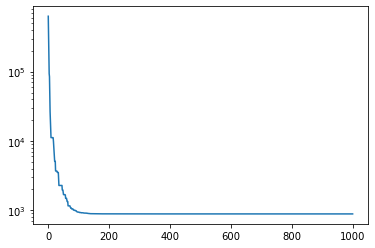

In [100]:
PSO ("a",10,100,6,1000) # PSO (funcname,n_dim,num_particles,num_informants,iterations) #27,13,10 see sc alpha 0.7 | got 5 too | 1.94 | 0.79

In [63]:
# output in certain range cuz if data goes up or down randomly, gives ability to have them similar to real data?
# even if 1k layers, linear rel so no learning ahppens; output is linear; all rel are actually non linear; linear is non realistic; irrespective of no of layers or outputs, if linearonly used, all these reduce to work as 1 layer
# monotonic, differentiable, 

In [96]:
#!/usr/bin/env python

'''
pso.py
A simple implementation of the Particle Swarm Optimisation Algorithm.
Uses Numpy for matrix operations. 
Adapted from Pradeep Gowda 2009-03-16.
This implementation optimises the Schaffer function (f6).
It uses only global update. Informants are not used.
It can be generalised by adding:
- random or local informants and consider them when updating velocity
- generate random numbers for each dimension and use them to weigh the terms  in the update equation
To use it for training an ANN model, two things must be done:
- set param to be the aray of all weights and biases of the ANN
- replace f6 function by the loss functio of the ANN

'''

from numpy import array
from random import random
from math import sin, sqrt

iter_max = 10000
pop_size = 100
dimensions = 2
c1 = 2
c2 = 2
err_crit = 0.00001

class Particle:
    pass
        

def f6(param):
    '''Schaffer's F6 function'''
    para = param*10
    para = param[0:2]
    num = (sin(sqrt((para[0] * para[0]) + (para[1] * para[1])))) * \
        (sin(sqrt((para[0] * para[0]) + (para[1] * para[1])))) - 0.5
    denom = (1.0 + 0.001 * ((para[0] * para[0]) + (para[1] * para[1]))) * \
            (1.0 + 0.001 * ((para[0] * para[0]) + (para[1] * para[1])))
    f6 =  0.5 - (num/denom)
    errorf6 = 1 - f6
    return f6, errorf6;


 
#initialize the particles
particles = []
for i in range(pop_size):
    p = Particle()
    p.params = array([random() for i in range(dimensions)])
    p.fitness = 0.0
    p.v = 0.0
    particles.append(p)

# let the first particle be the global best
gbest = particles[0]
err = 999999999
while i < iter_max :
    for p in particles:
        fitness,err = f6(p.params)
        if fitness > p.fitness:
            p.fitness = fitness
            p.best = p.params

        if fitness > gbest.fitness:
            gbest = p
        v = p.v + c1 * random() * (p.best - p.params) \
                + c2 * random() * (gbest.params - p.params)
        p.params = p.params + v
          
    i  += 1
    if err < err_crit:
        break
    #progress bar. '.' = 10%
    if i % (iter_max/10) == 0:
        print ('.')

print ('\nParticle Swarm Optimisation\n')
print ('PARAMETERS\n','-'*9)
print ('Population size : ', pop_size)
print ('Dimensions      : ', dimensions)
print ('Error Criterion : ', err_crit)
print ('c1              : ', c1)
print ('c2              : ', c2)
print ('function        :  f6')

print ('RESULTS\n', '-'*7)
print ('gbest fitness   : ', gbest.fitness)
print ('gbest params    : ', gbest.params)
print ('iterations      : ', i+1)
# Uncomment to print particles
for p in particles:
    print ('params: %s, fitness: %s, best: %s' % (p.params, p.fitness, p.best))


Particle Swarm Optimisation

PARAMETERS
 ---------
Population size :  100
Dimensions      :  2
Error Criterion :  1e-05
c1              :  2
c2              :  2
function        :  f6
RESULTS
 -------
gbest fitness   :  0.9999999828128807
gbest params    :  [-1.10493568e-04  7.04352250e-05]
iterations      :  107
params: [0.00806323 0.00898432], fitness: 0.999973346723511, best: [-0.00105981  0.00505012]
params: [ 0.00077034 -0.00407037], fitness: 0.9999129501142303, best: [0.00069132 0.00929987]
params: [0.02439527 0.01566625], fitness: 0.9999460603964154, best: [0.00318303 0.00661476]
params: [0.0003068  0.00040616], fitness: 0.999975479264462, best: [-0.00490451  0.00066501]
params: [0.00074401 0.00038444], fitness: 0.9999992979462807, best: [0.00074401 0.00038444]
params: [0.00080152 0.00032457], fitness: 0.9999974099472348, best: [ 0.0015446  -0.00044907]
params: [0.0015215  0.00111948], fitness: 0.9999949572919778, best: [0.00178149 0.00136528]
params: [0.00120908 0.00033092], f

In [23]:
#--- IMPORT DEPENDENCIES ------------------------------------------------------+

from __future__ import division
import random
import math

#--- COST FUNCTION ------------------------------------------------------------+

# function we are attempting to optimize (minimize)
def func1(x):
    total=0
    for i in range(len(x)):
        total+=x[i]**2
    return total



#--- MAIN ---------------------------------------------------------------------+

class Particle:
    def __init__(self,x0):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(random.uniform(-1,1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.5       # constant inertia weight (how much to weigh the previous velocity)
        c1=1        # cognative constant
        c2=2        # social constant

        for i in range(0,num_dimensions):
            r1=random.random()
            r2=random.random()

            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            # adjust maximum position if necessary
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            # adjust minimum position if neseccary
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i]=bounds[i][0]
                
class PSO():
    def __init__(self,costFunc,x0,bounds,num_particles,maxiter):
        global num_dimensions

        num_dimensions=len(x0)
        err_best_g=-1                   # best error for group
        pos_best_g=[]                   # best position for group

        # establish the swarm
        swarm=[]
        for i in range(0,num_particles):
            swarm.append(Particle(x0))

        # begin optimization loop
        i=0
        while i < maxiter:
            #print i,err_best_g
            # cycle through particles in swarm and evaluate fitness
            for j in range(0,num_particles):
                swarm[j].evaluate(costFunc)

                # determine if current particle is the best (globally)
                if swarm[j].err_i < err_best_g or err_best_g == -1:
                    pos_best_g=list(swarm[j].position_i)
                    err_best_g=float(swarm[j].err_i)

            # cycle through swarm and update velocities and position
            for j in range(0,num_particles):
                swarm[j].update_velocity(pos_best_g)
                swarm[j].update_position(bounds)
            i+=1

        # print final results
        print ('FINAL:')
        print (pos_best_g)
        print (err_best_g)

if __name__ == "__PSO__":
    main()

#--- RUN ----------------------------------------------------------------------+

initial=[5,5]               # initial starting location [x1,x2...]
bounds=[(-10,10),(-10,10)]  # input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
PSO(func1,initial,bounds,num_particles=15,maxiter=30)

#--- END ----------------------------------------------------------------------+

FINAL:
[-0.006532716491215517, -0.00319064036347275]
5.28565706836207e-05


In [30]:
import random
import math
#import the set of functions F1 to F25
# function can have multiple variables 1 to 100 
from optproblems import cec2005
#import the Individual class that represent any individual solution
# this class has two main attributes 
# phenome: the actual values of the variables
# objective_values: the value(s) of the function after evaluation of the Individual
# the function evaluate() needs to be executed in order to get objective_values
from optproblems import Individual

# import BoundConstraintsRepair to repair variables that go out of bounds
from optproblems import BoundConstraintsRepair

#number of dimensions. 
# Note that for many functions the number of variables is limited to 2, 10, 30, 50
dims = 10
# setup objective function
#f1 = cec2005.F1(dims)
#func = f1
#set up bounds, each function has bounds on the variables
#min_bound = -100
#max_bound = 100
# the function can be anyone from CEC2005, e.g.
#f4=cec2005.F4(dims)
#func= f4
#set up bounds, each function has bounds on the variables
#min_bound = -100
#max_bound = 100
##or
#f5=cec2005.F4(dims)
#func= f5
#set up bounds, each function has bounds on the variables
#min_bound = -100
#max_bound = 100
#or
f12=cec2005.F12(dims)
func= f12
#set up bounds, each function has bounds on the variables
min_bound = -math.pi
max_bound = math.pi 

# create  bounds
bounds = ([min_bound] * dims, [max_bound] * dims)

#create the out of bounds repair method
# different options exist to repair, "reflect" is one of them
# you can also use "project", "wrap", 
repair = BoundConstraintsRepair(bounds, ["reflect"] * dims)
# obtain the global optimal solution
# global_optima is returned as a list of Individual to allow for multiple optima, usefull for some multimodal functions
global_optima = func.get_optimal_solutions()
#evaluate the global optimal solution

func.batch_evaluate(global_optima)
print("global solution and  associated objective values:")
for opt in global_optima:
    print(opt.phenome,opt.objective_values)

# create a random candidate solution (an Individual) using a random vector generated within bounds
# the solution is encapsulated in an Individual object in order to evaluate it
rand_solution = Individual(phenome=[round(random.uniform(min_bound, max_bound),4) for _ in range(dims)])

# here you might want to create a population of solutions
#  evaluate them and then 
#  evolve them according to PSO or GA

# You need to keep individual solutions within bounds
rand_solution.phenome = repair(rand_solution.phenome)
# you might want to check bounds first before repair
#  for that, you can use the class BoundConstraintError
#  with the boolea methods: min_bound_violated(value, min_bound) and max_bound_violated(value, max_bound)

#evaluate the random candidate solution
func.evaluate(rand_solution)


print("Random candidate solution and objective values:")  
#print the radom candidate solution and the associated objective values
print(rand_solution.phenome, rand_solution.objective_values)




global solution and  associated objective values:
[-2.028, -1.5589, 0.7774, -2.0752, -0.1601, 1.0811, 1.408, -1.6129, 2.419, 2.217] -460.0
Random candidate solution and objective values:
[3.104, 1.5268, 2.9606, -1.9234, -1.8593, 1.5603, -2.1717, 1.5253, 1.7065, -1.1432] 1193654.4525372537
